# Riak

In [ ]:
import riak
from pprintpp import pprint as pp
import json
import pandas as pd

import uuid
import hashlib

## Lectura de información en Pandas

Partimos del dataset normalizado y lo desnormalizamos para guardarlo todo junto en RIAK

In [ ]:
df_mov = pd.read_excel("./data/black.xlsx", sheet_name= "Movimientos",  engine='openpyxl')
df_miembros = pd.read_excel("./data/black.xlsx", sheet_name= "Miembros",  engine='openpyxl')
df = pd.merge(df_mov, df_miembros, on = ['id_miembro'], how = 'inner')
df.info()

In [ ]:
df.head(5)

## Funciones de Utilidad

### Funcion para convertir una lista de JSON a Pandas

En la siguiente función partimos del objeto JSON que nos devuelve RIAK y generamos un DataFrame Pandas.

En el caso de la fecha, lo convertimos desde un UNIX Timestamp al formato correcto para Pandas

In [ ]:
def json_to_pandas(rows):
    # Convertimos el objeto JSON en un objeto pandas 
    df = pd.read_json(json.dumps(rows))
    
    if 'fecha' in df.columns:
        # Las fechas están en formato UNIX TIMESTAMP. Las volvemos a convertir a formato Date...
        df = df.assign(fecha = pd.to_datetime(df.fecha, unit = 'ms'))

    return df

In [ ]:
values = [
    { "column1" : 1, "column2": 2 },
    { "column1" : 13, "column2": 23 }
]

json_to_pandas(values)
    

### Funcion para obtener el código Hash de un String

La siguiente función convertirá un String a un código HASH que tiene la propiedad de ser siempre el mismo para un determinado String

In [ ]:
def hash_string(value):
    value_utf8 = value.encode('utf-8')
    return hashlib.md5(value_utf8).hexdigest()

In [ ]:
print(hash_string("Nombre Apellido"))

In [ ]:
print(hash_string("Nombre Apellido"))

In [ ]:
print(hash_string("Nombre Otro Apellido"))

## Riak ...

In [ ]:
# connect to database
cliente = riak.RiakClient()
cliente.ping()

Utilizamos un bucket para guardar los movimientos en formato JSON y otro para guardar el importe acumulado por miembro, que nos servirá para contestar a una de las preguntas del caso de uso

En el bucket de movimientos utilizamos una clave autogenerada, ya que en el dataset no hay ningún campo que sea clavé única. Sin embargo tendremos un índice que nos permitira localizar los movimientos de una determinada persona. La clave del índice utilizaremos un código HASH debido a que un código de Riak no puede tener ni acentos ni espacios.

En el bucket con el importe acumulado la clave es el nombre de la persona en formato HASH, para no tener problemas ni con los espacios del nombre ni con los acentos. En este caso sólo hay un registro por cada persona del dataset. Utilizaremos un **mapa** en lugar de un JSON para poder utilizar la funcionalidad de de **contadores** de Riak

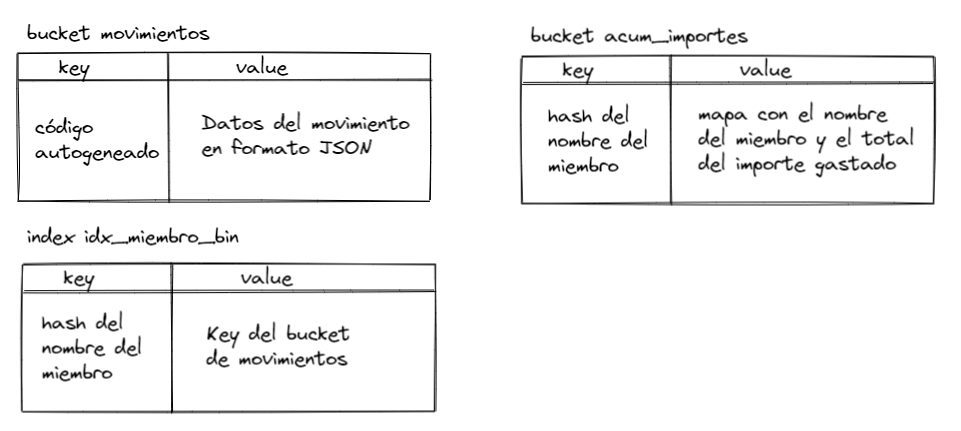

In [ ]:
BUCKET_MOVIMIENTOS = 'movimientos'
BUCKET_ACUM_IMPORTES = 'acum_importes'

bucket_mov = cliente.bucket(BUCKET_MOVIMIENTOS)
bucket_acum_importes = cliente.bucket_type('maps').bucket(BUCKET_ACUM_IMPORTES)

Función para eliminar los datos de un BUCKET de Riak

In [ ]:
# Se permiten operaciones de listado (No utilizar en PRODUCCION!)
riak.disable_list_exceptions = True

In [ ]:
def drop_keys(bucket):
    for keys in bucket.stream_keys():
        for key in keys:
            bucket.delete(key)

In [ ]:
# Borramos los datos ..
drop_keys(bucket_mov)
drop_keys(bucket_acum_importes)

In [ ]:
riak.disable_list_exceptions = False

## Inserción de información en Riak

Para generar los datos en formato JSON partimos del DataFrame de Pandas y lo exportamos a JSON (en formato String) para luego cargarlo en un diccionario de Python

Observa que cuando se genera el dato en formato JSON, los campos fechas se almacenan como un [TIMESTAMP de unix](http://www.unixtimestamp.com), por lo que habría que volver a convertirlo a fecha según el caso

In [ ]:
json_string = df.to_json(orient = 'records')
json_list = json.loads(json_string)

In [ ]:
print(len(json_list))

In [ ]:
pp(json_list[0])

Recorremos el dataset de movimientos, almacenando la información tanto en el bucket de movimientos como en el bucket que acumula los movimientos por cliente.

En este último utilizamos una funcionalidad que nos da Riak para guardar la información tipificada. Utilizamos un mapa que tiene dos elementos: Un registro donde guardamos el nombre del cliente y un contador donde guardamos el importe sin decimales

Vamos a utilizar el nombre de la persona como clave tanto en el índice de la tabla de movimientos, como en el bucket de importes acumulados, por lo que necesitamos convertirla previamente a un código que no lleve ni espacios ni acentos. Para ello utilizaremos la función que convierte un String a un código Hash!

Como el contador no puede guardar datos decimimales, convertimos el importe a un entero multiplicando por 100. Cuando recuperemos la informacion devemos de dividir por 100 para volver a tener decimales

In [ ]:
# Bucle de carga de datos ...
for index, movimiento_json in enumerate(json_list):
    key = uuid.uuid4().hex
    hash_nombre =  hash_string(movimiento_json["nombre"])
    
    movimiento = bucket_mov.new(key, movimiento_json)
    movimiento.add_index('idx_miembro_bin', hash_nombre)
    movimiento.store()
    
    map_nombre = bucket_acum_importes.new(hash_nombre)
    map_nombre.registers['nombre'].assign(movimiento_json["nombre"])
    map_nombre.counters['importe'].increment(int(round(movimiento_json["importe"] * 100)))
    map_nombre.store()
    
    if index % 500 == 0:
        print(index)

Comprobamos que los datos están correctos en los 3 primeros registros

In [ ]:
riak.disable_list_exceptions = True

values = []
for key in bucket_mov.get_keys()[0:3]:
    data = bucket_mov.get(key).data
    values.append(data)
    
riak.disable_list_exceptions = False

json_to_pandas(values)

Ahora mostramos los datos del bucket con los datos acumulados ...

In [ ]:
riak.disable_list_exceptions = True

for key in bucket_acum_importes.get_keys()[0:3]:
    data = bucket_acum_importes.get(key).value
    print('%s -> %s' % (key, data))

riak.disable_list_exceptions = False

# Lectura de información en Riak

### Lectura del bucket de movimientos

Cargamos todos los movimientos de la base de datos y lo guardamos en un objeto Pandas, ya que hay ciertas preguntas que no pueden resolverse directamente por esta base de datos

Recuerda que RIAK permite obtener información de un clave, pero no le es posible devolver la información ordenada ...

In [ ]:
rows = []
riak.disable_list_exceptions = True
for keys in bucket_mov.stream_keys():
    for key in keys:
        # print('Key %s' % key )
        rows.append(bucket_mov.get(key).data)

riak.disable_list_exceptions = False        
# Convertimos el objeto json en un objeto pandas 
df_movimientos = json_to_pandas(rows)

In [ ]:
df_movimientos.head()

### Los 10 movimientos mas caros

Esta consulta no la podemos contestar directamente con la Base de Datos por lo que nos apoyamos en un proceso en el cliente

In [ ]:
df_movimientos \
    .sort_values('importe', ascending=False)\
    .filter(['nombre', 'fecha', 'actividad_completa', 'importe']) \
    .head(10)

### Los movimientos de una persona concreta

Para obtener los movimientos de una persona en concreto si podemos **utilizar el índice** que habíamos creado Ad-hoc, aunque la ordenación se realiza en Pandas

In [ ]:
rows = []
keys = bucket_mov.stream_index("idx_miembro_bin", hash_string(u"Ildefonso José Sánchez Barcoj"))
for keys in keys.results:
    for movimiento_key in keys:
        rows.append(bucket_mov.get(movimiento_key).data)
    
df = json_to_pandas(rows)

In [ ]:
df \
    .sort_values('importe', ascending=False) \
    .filter(['nombre', 'fecha', 'actividad_completa', 'importe']) \
    .head(10)

### Las 10 personas que mas han gastado

Hemos creado un bucket especifico con información agregada para poder contestar a esta pregunta. Como la información está en un **mapa** la tenemos que convertir a JSON para poder visualizarla con Pandas

In [ ]:
rows = []
riak.disable_list_exceptions = True
for keys in bucket_acum_importes.stream_keys():
    #print(keys)
    for key in keys:
        map_nombre = bucket_acum_importes.get(key)
        rows.append({'nombre' : map_nombre.registers['nombre'].value,
                     "importe" : float(map_nombre.counters['importe'].value) / 100})
        
riak.disable_list_exceptions = False

# Convertimos el objeto json en un objeto pandas 
df = json_to_pandas(rows)

Utilizamos Pandas para ordenar la información ..,

In [ ]:
df.sort_values('importe', ascending=False).head(10)